# Prediction of Blueberry Yield
Kaggle Playground Series - Season 3, Episode 14

## Features Description

- Clonesize (m2) - The average blueberry clone size in the field
- Honeybee (bees/m2/min) - Honeybee density in the field
- Bumbles (bees/m2/min) - Bumblebee density in the field
- Andrena (bees/m2/min) - Andrena bee density in the field
- Osmia (bees/m2/min) - Osmia bee density in the field
- MaxOfUpperTRange (℃) - The highest record of the upper band daily air temperature during the bloom season
- MinOfUpperTRange (℃) - The lowest record of the upper band daily air temperature
- AverageOfUpperTRange (℃) - The average of the upper band daily air temperature
- MaxOfLowerTRange (℃) - The highest record of the lower band daily air temperature
- MinOfLowerTRange (℃) - The lowest record of the lower band daily air temperature
- AverageOfLowerTRange (℃) - The average of the lower band daily air temperature
- RainingDays Day - The total number of days during the bloom season, each of which has precipitation larger than zero
- AverageRainingDays (days) - The average of raining days of the entire bloom season
- Fruitset (%) - Percentage of flowers that successfully develop into fruit.
- Fruitmass (g) - The weight of each blueberry fruit
- Seeds - The number of seeds for each fruit

## Import Libraries and Load Data

In [ ]:
# EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from helper_functions import data_summary, show_outliers, remove_outliers, corr_heatmap
import seaborn as sns

# Model building
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor,GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
import optuna

# Warnings
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

In [537]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

display(df_train.head())
display(df_test.head())

,id,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
0,0,25.0,0.50,0.25,0.75,0.50,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.425011,0.417545,32.460887,4476.81146
1,1,25.0,0.50,0.25,0.50,0.50,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.444908,0.422051,33.858317,5548.12201
2,2,12.5,0.25,0.25,0.63,0.63,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.552927,0.470853,38.341781,6869.77760
3,3,12.5,0.25,0.25,0.63,0.50,77.4,46.8,64.7,55.8,27.0,45.8,24.0,0.39,0.565976,0.478137,39.467561,6880.77590
4,4,25.0,0.50,0.25,0.63,0.63,77.4,46.8,64.7,55.8,27.0,45.8,24.0,0.39,0.579677,0.494165,40.484512,7479.93417


,id,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds
0,15289,25.0,0.25,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.399367,0.408088,31.394569
1,15290,12.5,0.25,0.25,0.75,0.63,94.6,57.2,79.0,68.2,33.0,55.9,1.0,0.10,0.488048,0.442866,36.846956
2,15291,12.5,0.25,0.25,0.63,0.63,86.0,52.0,71.9,62.0,30.0,50.8,16.0,0.26,0.583379,0.487057,40.037644
3,15292,25.0,0.50,0.38,0.38,0.63,86.0,52.0,71.9,62.0,30.0,50.8,16.0,0.26,0.433014,0.422847,33.116091
4,15293,37.5,0.75,0.25,0.25,0.25,94.6,57.2,79.0,68.2,33.0,55.9,24.0,0.39,0.360996,0.388860,29.558019


First we can see that we need to drop the ID column:

In [538]:
df_train.drop('id', axis=1, inplace=True)
df_test.drop('id', axis=1, inplace=True)

## Analysis of Data

We can use a previously defined helped function to get an overview of the data:

In [539]:
data_summary(df_train)

Dataset has 16 features and 15289 samples


,Count,Unique,Missing,Duplicated,Std,Mode,Median,Mean,Min,Max,First Value,Last Value,Types
clonesize,15289.0,6,0,7,6.595211,25.000000,25.000000,19.704690,10.000000,40.000000,25.000000,25.000000,float64
honeybee,15289.0,7,0,7,0.361643,0.500000,0.500000,0.389314,0.000000,18.430000,0.500000,0.500000,float64
bumbles,15289.0,11,0,7,0.059917,0.250000,0.250000,0.286768,0.000000,0.585000,0.250000,0.250000,float64
andrena,15289.0,16,0,7,0.148115,0.380000,0.500000,0.492675,0.000000,0.750000,0.750000,0.630000,float64
osmia,15289.0,14,0,7,0.139489,0.630000,0.630000,0.592355,0.000000,0.750000,0.500000,0.500000,float64
MaxOfUpperTRange,15289.0,6,0,7,9.146703,86.000000,86.000000,82.169887,69.700000,94.600000,69.700000,77.400000,float64
MinOfUpperTRange,15289.0,5,0,7,5.546405,52.000000,52.000000,49.673281,39.000000,57.200000,42.100000,46.800000,float64
AverageOfUpperTRange,15289.0,5,0,7,7.641807,71.900000,71.900000,68.656256,58.200000,79.000000,58.200000,64.700000,float64
MaxOfLowerTRange,15289.0,6,0,7,6.610640,62.000000,62.000000,59.229538,50.200000,68.200000,50.200000,55.800000,float64
MinOfLowerTRange,15289.0,7,0,7,3.195367,30.000000,30.000000,28.660553,24.300000,33.000000,24.300000,27.000000,float64


In [540]:
data_summary(df_test)

Dataset has 15 features and 10194 samples


,Count,Unique,Missing,Duplicated,Std,Mode,Median,Mean,Min,Max,First Value,Last Value,Types
clonesize,10194.0,5,0,3,6.591864,25.000000,25.000000,19.795958,10.000000,37.500000,25.000000,12.500000,float64
honeybee,10194.0,7,0,3,0.390022,0.500000,0.500000,0.391606,0.000000,18.430000,0.250000,0.250000,float64
bumbles,10194.0,8,0,3,0.059867,0.250000,0.250000,0.286307,0.000000,0.585000,0.250000,0.250000,float64
andrena,10194.0,12,0,3,0.148166,0.380000,0.500000,0.491328,0.000000,0.750000,0.250000,0.500000,float64
osmia,10194.0,14,0,3,0.139897,0.630000,0.630000,0.593222,0.000000,0.750000,0.250000,0.500000,float64
MaxOfUpperTRange,10194.0,7,0,3,9.153442,86.000000,86.000000,82.207014,69.700000,94.600000,86.000000,77.400000,float64
MinOfUpperTRange,10194.0,6,0,3,5.552286,52.000000,52.000000,49.697204,39.000000,57.200000,52.000000,46.800000,float64
AverageOfUpperTRange,10194.0,6,0,3,7.647629,71.900000,71.900000,68.687816,58.200000,79.000000,71.900000,64.700000,float64
MaxOfLowerTRange,10194.0,5,0,3,6.617055,62.000000,62.000000,59.256465,50.200000,68.200000,62.000000,55.800000,float64
MinOfLowerTRange,10194.0,5,0,3,3.198282,30.000000,30.000000,28.674779,24.300000,33.000000,30.000000,27.000000,float64


We can see from above that despite all being continuous variables, many of the features only have a few unique values so it may be best to convert these to categorical features. 

Interestingly, our dataset's target variable contains only 776 unique values. This means that although we will still treat this as a regression problem, to ensure accurate predictions we should adjust our model's predictions to match the closest unique value in the set of unique target variable values. 

Firstly, we can simply remove our duplicate values from the training set:

In [541]:
print('Previous number of entries:', df_train.shape[0])

df_train = df_train.drop_duplicates()

print('New number of entries:', df_train.shape[0])

Previous number of entries: 15289
New number of entries: 15282


## Removing Outliers

Next we can use a previously defined function to look into outliers for each feature:

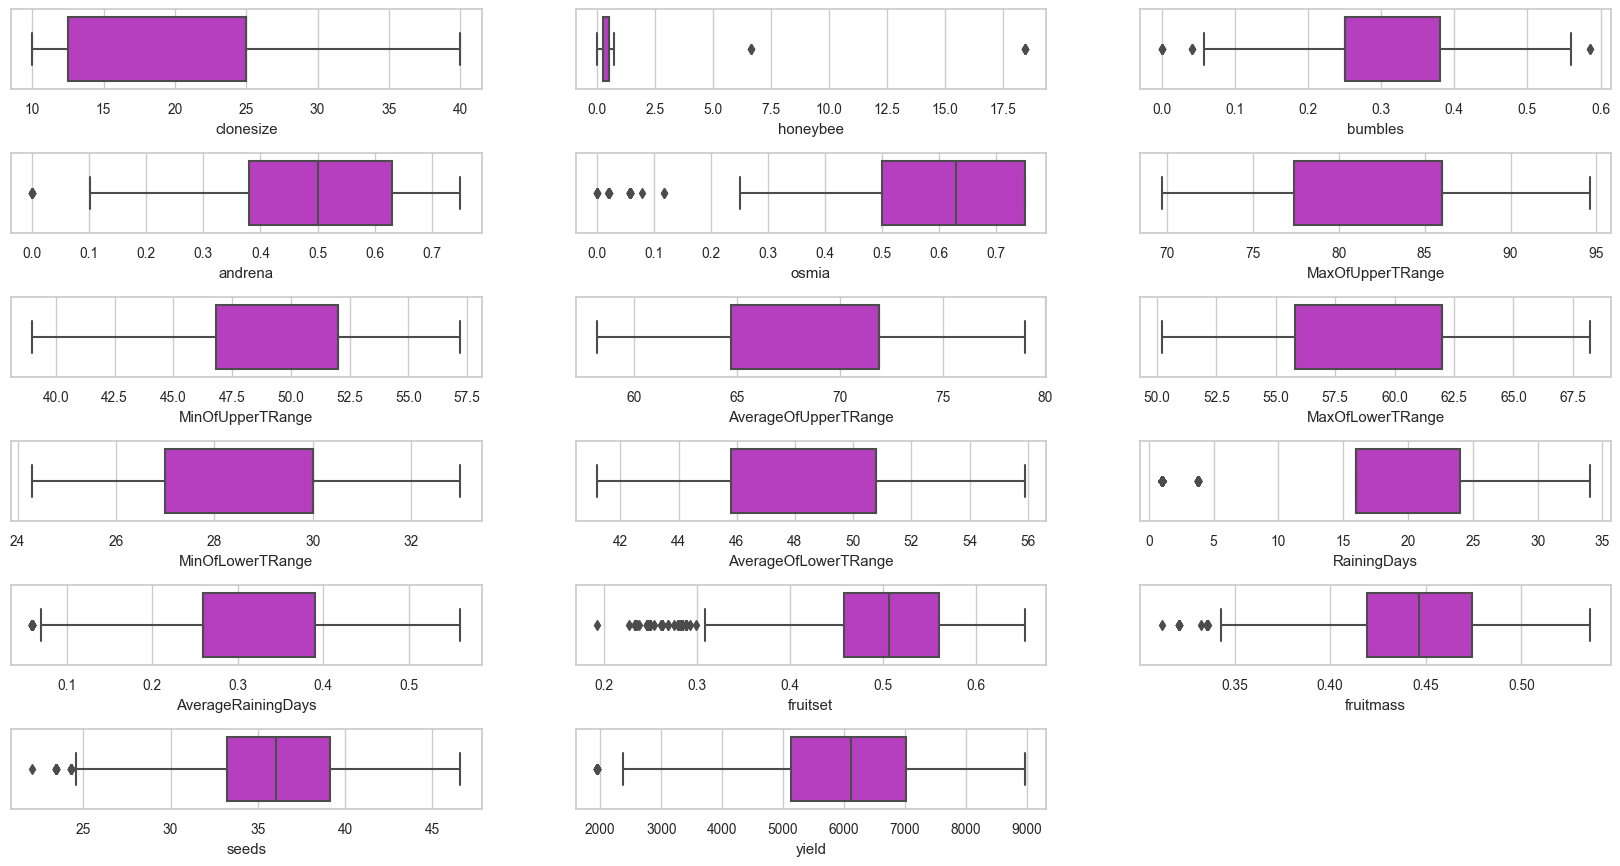

In [542]:
show_outliers(df_train, threshold=1.5)


We can use a pre-defined function to remove the outliers:

In [543]:
print('Previous number of entries:', df_train.shape[0])

df_train = remove_outliers(df_train, threshold=1.5)

print('New number of entries:', df_train.shape[0])

Previous number of entries: 15282
New number of entries: 11570


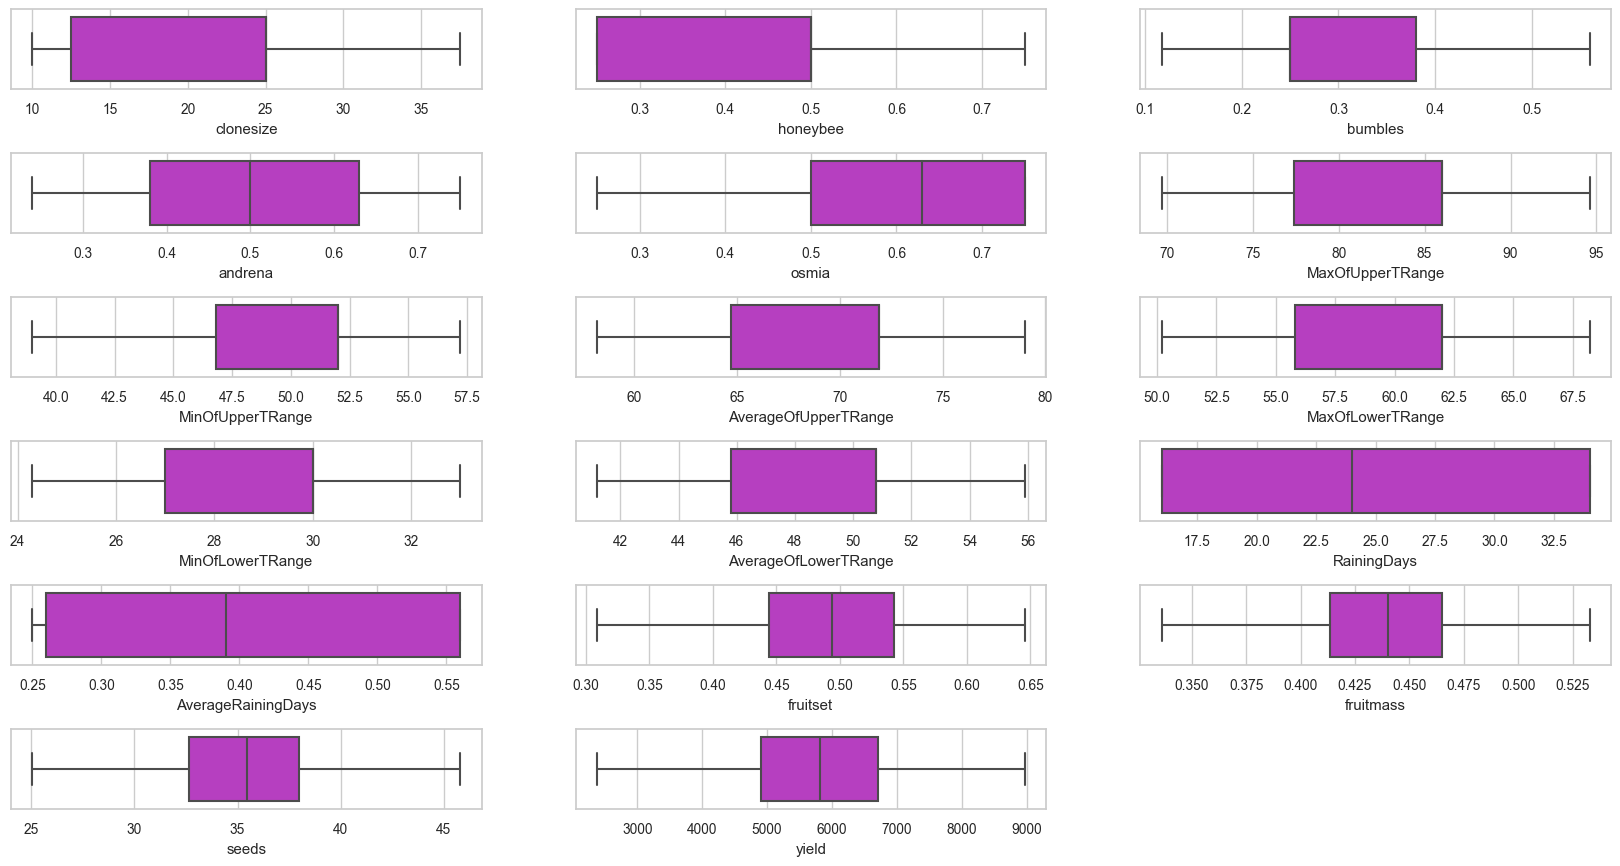

In [544]:
# We re-run this function to check they've all been removed
show_outliers(df_train, threshold=1.5)


## Converting Continuous Features to Categorical

### Clone Size

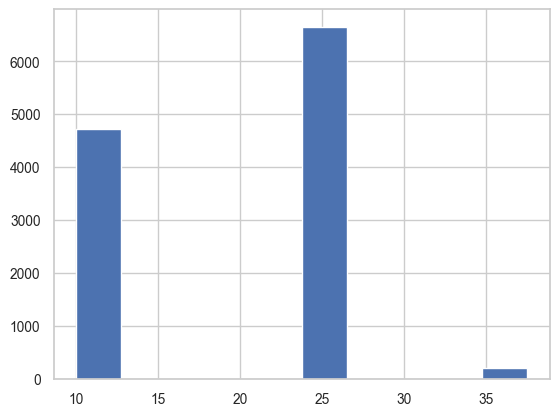

In [545]:
df_train['clonesize'].hist();

We can see that the vast majority of samples have one of two values for clonesize. We can look at the value counts below to confirm this:

In [546]:
df_train['clonesize'].value_counts()

clonesize
25.0    6651
12.5    4716
37.5     199
20.0       3
10.0       1
Name: count, dtype: int64

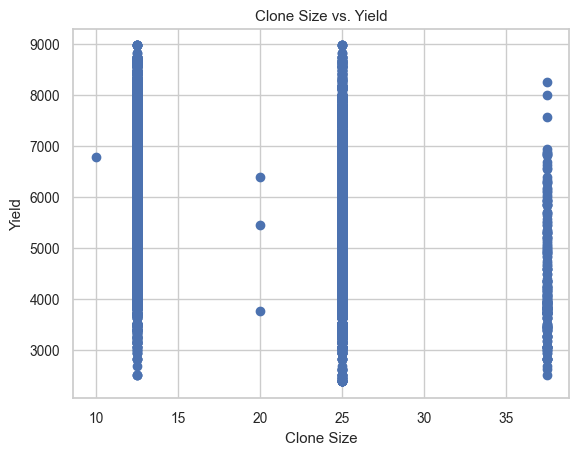

In [547]:
plt.scatter(df_train['clonesize'], df_train['yield'])
plt.xlabel('Clone Size')
plt.ylabel('Yield')
plt.title('Clone Size vs. Yield');

In [548]:
# Define the bin edges
bin_edges = [0, 15, 30, 45]
bin_labels = [1, 2, 3]


# Create a new column with the binned feature
df_train['clonesize_binned'] = pd.cut(df_train['clonesize'], bins=bin_edges, labels=bin_labels)
df_test['clonesize_binned'] = pd.cut(df_test['clonesize'], bins=bin_edges, labels=bin_labels)

In [549]:
df_train.groupby('clonesize_binned')['yield'].agg(['mean', 'median'])

,mean,median
clonesize_binned,,
1,6307.306263,6475.89456
2,5490.441118,5531.35174
3,4409.276445,4016.36160


We can see that these bins have quite distinct averages for yield so hopefully these should be a useful feature in our model. Finally, we can drop our orginal feature:

In [550]:
df_train = df_train.drop('clonesize', axis=1)
df_test = df_test.drop('clonesize', axis=1)

### Honey Bee

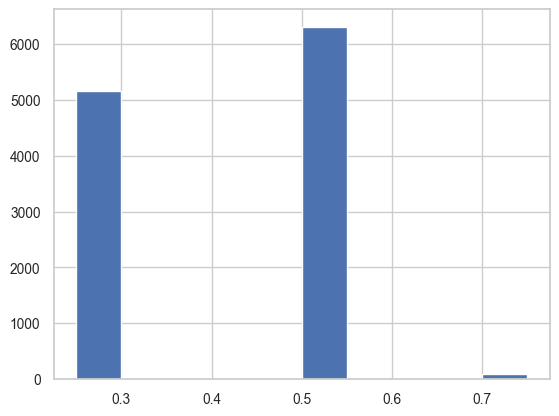

In [551]:
df_train['honeybee'].hist();

In [552]:
df_train['honeybee'].value_counts()

honeybee
0.500    6311
0.250    5165
0.750      93
0.537       1
Name: count, dtype: int64

We can see that this feature is also heavily in one of two values so we can similarly bin this feature

In [553]:
# Define the bin edges
bin_edges = [-np.inf, 0.3, 0.6, np.inf]
bin_labels = [1, 2, 3]


# Create a new column with the binned feature
df_train['honeybee_binned'] = pd.cut(df_train['honeybee'], bins=bin_edges, labels=bin_labels)
df_test['honeybee_binned'] = pd.cut(df_test['honeybee'], bins=bin_edges, labels=bin_labels)

In [554]:
# We can look into the new average yields for the bins
df_train.groupby('honeybee_binned')['yield'].agg(['mean', 'median'])

,mean,median
honeybee_binned,,
1,6155.625764,6292.96076
2,5536.035006,5566.52275
3,4571.449700,4234.86859


In [555]:
# Finally we drop the original column
df_train = df_train.drop('honeybee', axis=1)
df_test = df_test.drop('honeybee', axis=1)

### Bumblebee

<Axes: >

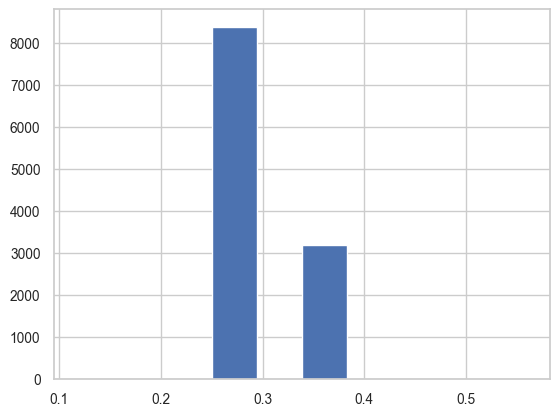

In [556]:
df_train.bumbles.hist()

In [557]:
df_train.bumbles.value_counts()

bumbles
0.250    8387
0.380    3181
0.560       1
0.117       1
Name: count, dtype: int64

We'll take the same approach with bumbles

In [558]:
# Define the bin edges
bin_edges = [-np.inf, 0.3, np.inf]
bin_labels = [1, 2]


# Create a new column with the binned feature
df_train['bumbles_binned'] = pd.cut(df_train['bumbles'], bins=bin_edges, labels=bin_labels)
df_test['bumbles_binned'] = pd.cut(df_test['bumbles'], bins=bin_edges, labels=bin_labels)

In [559]:
# We can look into the new average yields for the bins
df_train.groupby('bumbles_binned')['yield'].agg(['mean', 'median'])

,mean,median
bumbles_binned,,
1,5689.721705,5711.85174
2,6108.428408,6237.20605


In [560]:
# Finally we drop the original column
df_train = df_train.drop('bumbles', axis=1)
df_test = df_test.drop('bumbles', axis=1)

### Andrena Bee

<Axes: >

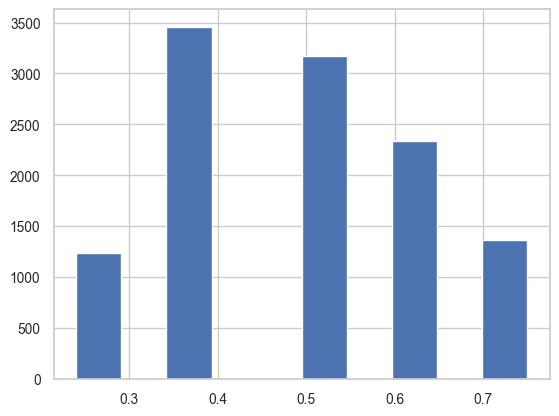

In [561]:
df_train.andrena.hist()

In [562]:
df_train.andrena.value_counts()

andrena
0.380    3458
0.500    3167
0.630    2337
0.750    1368
0.250    1235
0.490       2
0.240       1
0.560       1
0.409       1
Name: count, dtype: int64

In [563]:
# Define the bin edges
bin_edges = [-np.inf, 0.3, 0.45, 0.6, 0.7499999, np.inf]
bin_labels = [1, 2, 3, 4, 5]


# Create a new column with the binned feature
df_train['andrena_binned'] = pd.cut(df_train['andrena'], bins=bin_edges, labels=bin_labels)
df_test['andrena_binned'] = pd.cut(df_test['andrena'], bins=bin_edges, labels=bin_labels)

In [564]:
# We can look into the new average yields for the bins
df_train.groupby('andrena_binned')['yield'].agg(['mean', 'median'])

,mean,median
andrena_binned,,
1,5269.468449,5219.248585
2,5922.212507,6019.262480
3,5855.147137,5807.006930
4,5798.608776,5781.859650
5,5886.143023,5887.563310


In [565]:
# Finally we drop the original column
df_train = df_train.drop('andrena', axis=1)
df_test = df_test.drop('andrena', axis=1)

### Osmia Bee

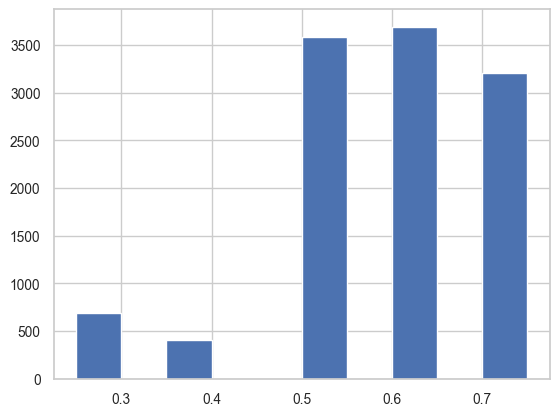

In [566]:
df_train.osmia.hist();

In [567]:
df_train.osmia.value_counts()

osmia
0.630    3690
0.500    3584
0.750    3205
0.250     685
0.380     404
0.620       1
0.606       1
Name: count, dtype: int64

In [568]:
# Define the bin edges
bin_edges = [-np.inf, 0.15, 0.3, 0.45, 0.6, 0.749999, np.inf]
bin_labels = [1, 2, 3, 4, 5, 6]


# Create a new column with the binned feature
df_train['osmia_binned'] = pd.cut(df_train['osmia'], bins=bin_edges, labels=bin_labels)
df_test['osmia_binned'] = pd.cut(df_test['osmia'], bins=bin_edges, labels=bin_labels)

In [569]:
# We can look into the new average yields for the bins
df_train.groupby('osmia_binned')['yield'].agg(['mean', 'median'])

,mean,median
osmia_binned,,
1,NaN,NaN
2,4860.507863,4740.015050
3,5446.080912,5556.374600
4,5804.922885,5828.732120
5,5882.304860,5879.962815
6,5962.691769,5948.114470


In [570]:
# Finally we drop the original column
df_train = df_train.drop('osmia', axis=1)
df_test = df_test.drop('osmia', axis=1)

### Temperature Range

We can see from the data that all the TRange values seem to be correlated with each other:

In [571]:
df_train.head()

,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield,clonesize_binned,honeybee_binned,bumbles_binned,andrena_binned,osmia_binned
0,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.425011,0.417545,32.460887,4476.81146,2,2,1,5,4
1,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.444908,0.422051,33.858317,5548.12201,2,2,1,3,4
2,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.552927,0.470853,38.341781,6869.77760,1,1,1,4,5
3,77.4,46.8,64.7,55.8,27.0,45.8,24.0,0.39,0.565976,0.478137,39.467561,6880.77590,1,1,1,4,4
4,77.4,46.8,64.7,55.8,27.0,45.8,24.0,0.39,0.579677,0.494165,40.484512,7479.93417,2,2,1,4,5


In [572]:
# We can also look at TRange colinearity values with each other 
df_train.corr(method='spearman').iloc[0:6,:]

,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield,clonesize_binned,honeybee_binned,bumbles_binned,andrena_binned,osmia_binned
MaxOfUpperTRange,1.000000,0.998545,0.999864,0.999512,0.999862,0.999768,0.002423,0.002489,0.002086,0.146713,0.045930,-0.036126,0.015962,0.013256,-0.005497,-0.009344,-0.027758
MinOfUpperTRange,0.998545,1.000000,0.998809,0.998231,0.998807,0.998912,0.002965,0.003031,0.002561,0.147179,0.046458,-0.035573,0.015779,0.013082,-0.005360,-0.009185,-0.027059
AverageOfUpperTRange,0.999864,0.998809,1.000000,0.999550,0.999982,0.999960,0.002497,0.002563,0.002197,0.146843,0.046085,-0.036050,0.015945,0.013245,-0.005271,-0.009299,-0.027880
MaxOfLowerTRange,0.999512,0.998231,0.999550,1.000000,0.999548,0.999454,0.002039,0.002105,0.002222,0.146620,0.046126,-0.035829,0.016088,0.013428,-0.004997,-0.009062,-0.027786
MinOfLowerTRange,0.999862,0.998807,0.999982,0.999548,1.000000,0.999958,0.002488,0.002554,0.002278,0.146909,0.046161,-0.035977,0.015947,0.013249,-0.005271,-0.009262,-0.027925
AverageOfLowerTRange,0.999768,0.998912,0.999960,0.999454,0.999958,1.000000,0.002616,0.002682,0.002371,0.147017,0.046257,-0.035968,0.016003,0.013294,-0.005194,-0.009379,-0.027902


Given that these values are all almost perfectly correlated with each other, we can drop all but one of them:

In [573]:
# Drop all but MaxOfUpperTRange
df_train = df_train.drop(df_train.columns[1:6], axis=1)
df_test = df_test.drop(df_test.columns[1:6], axis=1)

<Axes: >

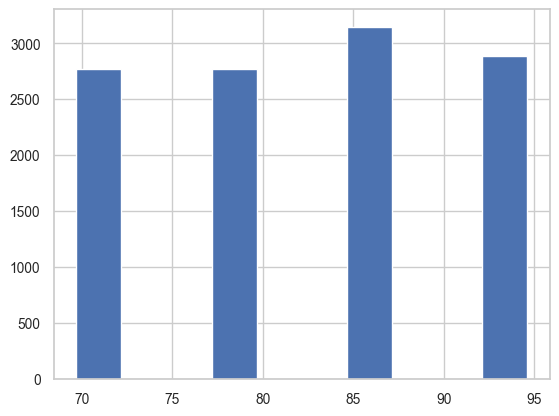

In [574]:
# We can look at a histogram of the remaining TRange value
df_train['MaxOfUpperTRange'].hist()

In [575]:
# We can look at the value counts
df_train['MaxOfUpperTRange'].value_counts()

MaxOfUpperTRange
86.0    3147
94.6    2885
77.4    2770
69.7    2766
89.0       1
79.0       1
Name: count, dtype: int64

We can similarly bin this feature like we have done with previous features:

In [576]:
# Define the bin edges
bin_edges = [-np.inf, 70, 80, 90, np.inf]
bin_labels = [1, 2, 3, 4]


# Create a new column with the binned feature
df_train['TRange_binned'] = pd.cut(df_train['MaxOfUpperTRange'], bins=bin_edges, labels=bin_labels)
df_test['TRange_binned'] = pd.cut(df_test['MaxOfUpperTRange'], bins=bin_edges, labels=bin_labels)

In [577]:
# We can look into the new average yields for the bins
df_train.groupby('TRange_binned')['yield'].agg(['mean', 'median'])

,mean,median
TRange_binned,,
1,5686.504200,5721.64996
2,6058.340224,6180.95142
3,5834.048492,5864.12845
4,5643.081047,5645.14663


In [578]:
# Finally we drop the original column
df_train = df_train.drop('MaxOfUpperTRange', axis=1)
df_test = df_test.drop('MaxOfUpperTRange', axis=1)

### Raining Days

Similarly to TRange, we can see that the two RainingDays features are heavily correlated with each other so one of them can be dropped:

In [579]:
df_train.corr(method='spearman').iloc[:2,:]


,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield,clonesize_binned,honeybee_binned,bumbles_binned,andrena_binned,osmia_binned,TRange_binned
RainingDays,1.00000,0.99956,-0.424943,-0.39730,-0.429501,-0.430468,0.112926,0.089290,-0.054393,-0.025607,-0.066179,0.002463
AverageRainingDays,0.99956,1.00000,-0.424527,-0.39694,-0.429210,-0.430030,0.112672,0.089007,-0.054309,-0.025600,-0.065941,0.002529


In [580]:
df_train = df_train.drop('AverageRainingDays', axis=1)
df_test = df_test.drop('AverageRainingDays', axis=1)

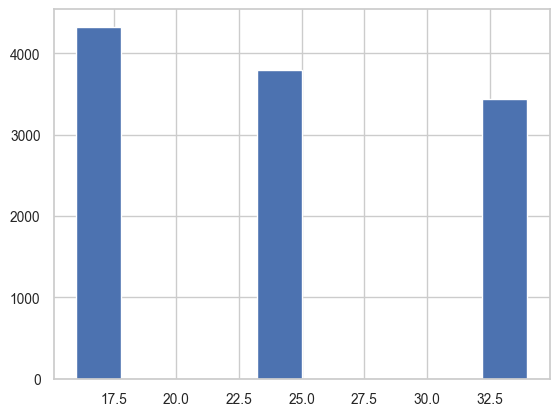

In [581]:
# We can look at a histogram
df_train['RainingDays'].hist();

In [582]:
# We can look at the value counts
df_train['RainingDays'].value_counts()

RainingDays
16.0    4326
24.0    3799
34.0    3444
26.0       1
Name: count, dtype: int64

Again we will split this feature into bins:

In [583]:
# Define the bin edges
bin_edges = [-np.inf, 20, 30, np.inf]
bin_labels = [1, 2, 3]


# Create a new column with the binned feature
df_train['rainingdays_binned'] = pd.cut(df_train['RainingDays'], bins=bin_edges, labels=bin_labels)
df_test['rainingdays_binned'] = pd.cut(df_test['RainingDays'], bins=bin_edges, labels=bin_labels)

In [584]:
# We can look into the new average yields for the bins
df_train.groupby('rainingdays_binned')['yield'].agg(['mean', 'median'])

,mean,median
rainingdays_binned,,
1,6422.171509,6528.79888
2,5696.879873,5696.02606
3,5148.649067,5042.64034


In [585]:
# Finally we drop the original column
df_train = df_train.drop('RainingDays', axis=1)
df_test = df_test.drop('RainingDays', axis=1)

In [586]:
df_test.head()

,fruitset,fruitmass,seeds,clonesize_binned,honeybee_binned,bumbles_binned,andrena_binned,osmia_binned,TRange_binned,rainingdays_binned
0,0.399367,0.408088,31.394569,2,1,1,1,2,3,2
1,0.488048,0.442866,36.846956,1,1,1,5,5,4,1
2,0.583379,0.487057,40.037644,1,1,1,4,5,3,1
3,0.433014,0.422847,33.116091,2,2,2,2,5,3,1
4,0.360996,0.388860,29.558019,3,3,1,1,2,4,2


### Fruitset, Fruitmass and Seeds

We can try and engineer some additional features from the above features. For example, the number of seeds per gram of fruit may be relevent here as might be both the fruit mass and the number of seeds multiplied by the percentage of flowers that fruit.

In [587]:
# Seeds per gram
df_train['seeds_per_gram'] = df_train['seeds'] / df_train['fruitmass']
df_test['seeds_per_gram'] = df_test['seeds'] / df_test['fruitmass']

# Total mass
df_train['total_mass'] = df_train['fruitset'] * df_train['fruitmass']
df_test['total_mass'] = df_test['fruitset'] * df_test['fruitmass']

# Total seeds
df_train['total_seeds'] = df_train['fruitset'] * df_train['seeds']
df_test['total_seeds'] = df_test['fruitset'] * df_test['seeds']

## Feature Selection

We can now look at correlation matrices for our features. 

In [588]:
df_train.head()

,fruitset,fruitmass,seeds,yield,clonesize_binned,honeybee_binned,bumbles_binned,andrena_binned,osmia_binned,TRange_binned,rainingdays_binned,seeds_per_gram,total_mass,total_seeds
0,0.425011,0.417545,32.460887,4476.81146,2,2,1,5,4,1,2,77.742172,0.177461,13.796231
1,0.444908,0.422051,33.858317,5548.12201,2,2,1,3,4,1,2,80.223209,0.187774,15.063846
2,0.552927,0.470853,38.341781,6869.77760,1,1,1,4,5,3,2,81.430491,0.260347,21.200199
3,0.565976,0.478137,39.467561,6880.77590,1,1,1,4,4,2,2,82.544539,0.270614,22.337712
4,0.579677,0.494165,40.484512,7479.93417,2,2,1,4,5,2,2,81.925130,0.286456,23.467926


In [589]:
# We get a dataframe just containing the continous features
df_train_num = df_train.drop(df_train.columns[3:11], axis=1)
df_train_num['yield'] = df_train['yield']

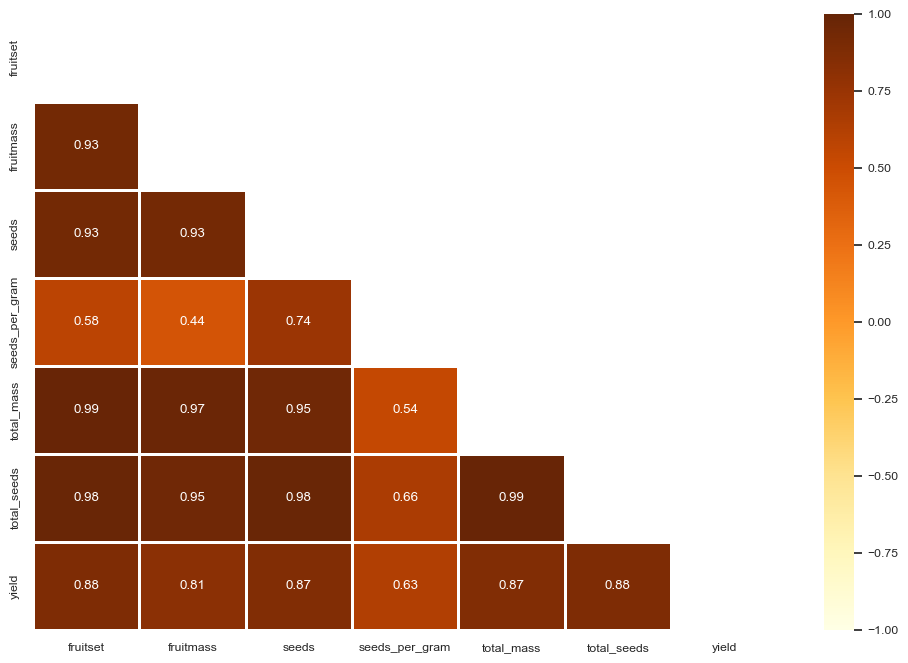

In [590]:
# Plot a correlation heatmap
corr_heatmap(df_train_num, 'pearson')

We can see here that all of these features have significant correlation with our target variable yield. However, many are also correlated with each other so we could drop some of them. However, since they are all highly correlated and we don't have a huge number of features, we can leave all the features for now and see how our model performs with all of the above numerical features.

In [591]:
df_train.head()

,fruitset,fruitmass,seeds,yield,clonesize_binned,honeybee_binned,bumbles_binned,andrena_binned,osmia_binned,TRange_binned,rainingdays_binned,seeds_per_gram,total_mass,total_seeds
0,0.425011,0.417545,32.460887,4476.81146,2,2,1,5,4,1,2,77.742172,0.177461,13.796231
1,0.444908,0.422051,33.858317,5548.12201,2,2,1,3,4,1,2,80.223209,0.187774,15.063846
2,0.552927,0.470853,38.341781,6869.77760,1,1,1,4,5,3,2,81.430491,0.260347,21.200199
3,0.565976,0.478137,39.467561,6880.77590,1,1,1,4,4,2,2,82.544539,0.270614,22.337712
4,0.579677,0.494165,40.484512,7479.93417,2,2,1,4,5,2,2,81.925130,0.286456,23.467926


Next we will look at the correlation of our categorical features:

In [592]:
# First define a dataframe containing only categorical features
df_train_cat = df_train.iloc[:, 4:11]
df_train_cat['yield'] = df_train['yield']

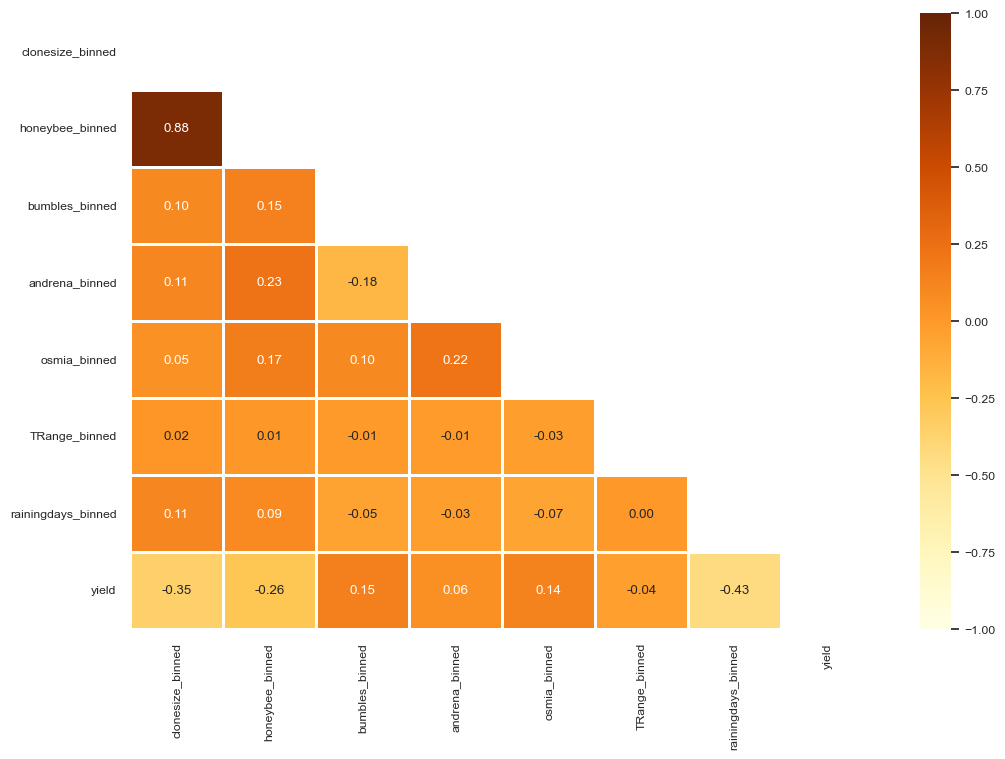

In [593]:
# Plot a correlation heatmap
corr_heatmap(df_train_cat, 'spearman')

Again, we can see that there is strong colinearity between clonesize and honeybee, and little correlation between andrena and TRange and the target variable. However, we will leave all the features in for now to see how the model performs at it is. 

Finally we convert all data values to type float so our dataset is ready to build some models:

In [594]:
df_train = df_train.apply(pd.to_numeric)
df_test = df_test.apply(pd.to_numeric)

## Model Building

First we define X and y and then we need to split our training dataset into a further train and validation set:

In [595]:
# Define X and y
X_train = df_train.drop('yield', axis=1)
y_train = df_train['yield']

In [596]:
# Train/Test split
X_train2, X_val, y_train2, y_val = train_test_split(
    X_train, y_train, test_size=0.3, random_state=42
)

We will first get some baseline model results:

In [480]:
# Linear Regression

# Scale data
ss = StandardScaler()
X_train2_ss = ss.fit_transform(X_train2)
X_val_ss = ss.transform(X_val)

# Create and fit model 
lr = LinearRegression()
lr.fit(X_train2_ss, y_train2)

# Create predictions
y_pred_lr = lr.predict(X_val_ss)

# Evaluate model
mae_lr = mean_absolute_error(y_pred_lr, y_val)


In [481]:
# Random Forest

# Create and fit model 
rf = RandomForestRegressor()
rf.fit(X_train2, y_train2)

# Create predictions
y_pred_rf = rf.predict(X_val)

# Evaluate model
mae_rf = mean_absolute_error(y_pred_rf, y_val)

In [482]:
# XGBoost

# Create and fit model 
xg = XGBRegressor()
xg.fit(X_train2, y_train2)

# Create predictions
y_pred_xg = xg.predict(X_val)

# Evaluate model
mae_xg = mean_absolute_error(y_pred_xg, y_val)

In [483]:
# Show results
print('Linear Regression Mean Absolute Error:', mae_lr.round(2))
print('Random Forest Mean Absolute Error:', mae_rf.round(2))
print('XGBoost Mean Absolute Error:', mae_xg.round(2))

Linear Regression Mean Absolute Error: 359.21
Random Forest Mean Absolute Error: 359.37
XGBoost Mean Absolute Error: 369.77


These are some good baseline model figures but we can see how they can be improved with some hyperparameter tuning using Optuna:

We cun use Optuna to build an Elastic Net model

In [597]:
def objective(trial):
    # Define hyperparameter ranges for the Elastic Net model
    params = {
        'alpha': trial.suggest_loguniform('alpha', 1e-6, 10),
        'l1_ratio': trial.suggest_uniform('l1_ratio', 0, 1),
        'max_iter': trial.suggest_int('max_iter', 100, 1000, step=100),
        'tol': trial.suggest_loguniform('tol', 1e-6, 1e-2)
    }

    # Train the Elastic Net model using cross-validation and return the average R2 score
    en = ElasticNet(**params)
    scores = cross_val_score(en, X_train2_ss, y_train2, cv=5, scoring='neg_mean_absolute_error')
    mae_mean = scores.mean()
    return mae_mean

study1 = optuna.create_study(direction='maximize')
study1.optimize(objective, n_trials=200)

[I 2023-05-11 11:46:15,555] A new study created in memory with name: no-name-41ba8257-4e9d-40be-b5be-ff51411b3881
[I 2023-05-11 11:46:15,892] Trial 0 finished with value: -362.91715289130263 and parameters: {'alpha': 0.0006926104646344934, 'l1_ratio': 0.5352927029175935, 'max_iter': 500, 'tol': 9.079343224711336e-05}. Best is trial 0 with value: -362.91715289130263.
[I 2023-05-11 11:46:15,928] Trial 1 finished with value: -395.39352119266835 and parameters: {'alpha': 2.3709783729171185, 'l1_ratio': 0.8116767179422639, 'max_iter': 100, 'tol': 0.0003214785423613585}. Best is trial 0 with value: -362.91715289130263.
[I 2023-05-11 11:46:16,007] Trial 2 finished with value: -363.4888693020067 and parameters: {'alpha': 3.258543791936195e-06, 'l1_ratio': 0.23251022471089478, 'max_iter': 100, 'tol': 1.915410708127371e-05}. Best is trial 0 with value: -362.91715289130263.
[I 2023-05-11 11:46:16,295] Trial 3 finished with value: -362.57446895574174 and parameters: {'alpha': 0.0001080895484277470

Now we can fit the model with the optimised parameters:

In [598]:
# Define random Elastic Net with optimised hyperparameters
en = ElasticNet(alpha=study1.best_params['alpha'],
                            l1_ratio=study1.best_params['l1_ratio'],
                            max_iter=study1.best_params['max_iter'],
                            tol=study1.best_params['tol'],
                            random_state=42)

# Fit the regressor with the training data
en.fit(X_train2_ss, y_train2)

# Make predictions on the test data
y_pred_en = en.predict(X_val_ss)

# Evaluate the performance of the model using mean absolute error
mae_en = mean_absolute_error(y_val, y_pred_en)

We can use Optuna to tune our hyperparameters for a Random Forest model:

In [486]:
# Define objective function for hyperparameter optimisation
def objective(trial):
    # Define hyperparameters to be optimized
    param = {
        'n_estimators' : trial.suggest_int('n_estimators', 50, 100),
        'max_depth' : trial.suggest_int('max_depth', 2, 10),
        'min_samples_split' : trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 1, 5)
    }
    
    # Create an XGBoost regressor model with the given hyperparameters
    rf = RandomForestRegressor(**param)

    # Compute cross-validation scores
    scores = cross_val_score(rf, X_train2, y_train2, cv=5, scoring='neg_mean_absolute_error')

    # Calculate the mean R2 score across cross-validation folds
    return scores.mean()

# Create an Optuna study and run the trials
study2 = optuna.create_study(direction='maximize') 
study2.optimize(objective, n_trials=200)

[I 2023-05-10 14:49:09,436] A new study created in memory with name: no-name-6036513c-135f-4963-b12e-eafe560f48b8
[I 2023-05-10 14:49:15,268] Trial 0 finished with value: -349.2699717266006 and parameters: {'n_estimators': 58, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 0 with value: -349.2699717266006.
[I 2023-05-10 14:49:26,310] Trial 1 finished with value: -348.7846346653113 and parameters: {'n_estimators': 99, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 1 with value: -348.7846346653113.
[I 2023-05-10 14:49:29,465] Trial 2 finished with value: -438.8288798504156 and parameters: {'n_estimators': 95, 'max_depth': 2, 'min_samples_split': 8, 'min_samples_leaf': 5}. Best is trial 1 with value: -348.7846346653113.
[I 2023-05-10 14:49:35,719] Trial 3 finished with value: -350.15811290368373 and parameters: {'n_estimators': 55, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 1 with value: -348

Now we can fit the model with the optimised parameters:

In [487]:
# Define random forest regressor with optimised hyperparameters
rf = RandomForestRegressor(n_estimators=study2.best_params['n_estimators'],
                            max_depth=study2.best_params['max_depth'],
                            min_samples_split=study2.best_params['min_samples_split'],
                            min_samples_leaf=study2.best_params['min_samples_leaf'],
                            random_state=42)

# Fit the regressor with the training data
rf.fit(X_train2, y_train2)

# Make predictions on the test data
y_pred_rf = rf.predict(X_val)

# Evaluate the performance of the model using mean absolute error
mae_rf = mean_absolute_error(y_val, y_pred_rf)

In [488]:
# Define objective function for hyperparameter optimisation
def objective(trial):

    # Define hyperparameters to be optimised
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 100),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'objective': 'reg:squarederror',
        'random_state': 42
    }


    # Create an XGBoost regressor model with the given hyperparameters
    xg = XGBRegressor(**param)

    # Compute cross-validation scores
    scores = cross_val_score(xg, X_train2, y_train2, cv=5, scoring='neg_mean_absolute_error')

    # Calculate the mean R2 score across cross-validation folds
    return scores.mean()

# Create an Optuna study and run the trials
study3 = optuna.create_study(direction='maximize') 
study3.optimize(objective, n_trials=200)

[I 2023-05-10 15:21:23,271] A new study created in memory with name: no-name-9a1a28b7-f4bb-40be-bbfe-fef9aad04337
[I 2023-05-10 15:21:24,002] Trial 0 finished with value: -4701.608694534605 and parameters: {'n_estimators': 59, 'max_depth': 8, 'learning_rate': 0.0036122492080006012, 'subsample': 0.9109292793071715, 'colsample_bytree': 0.6217177174139737, 'min_child_weight': 1}. Best is trial 0 with value: -4701.608694534605.
[I 2023-05-10 15:21:25,009] Trial 1 finished with value: -348.7512702545987 and parameters: {'n_estimators': 97, 'max_depth': 5, 'learning_rate': 0.061180322968985484, 'subsample': 0.5512998466284516, 'colsample_bytree': 0.693799817568485, 'min_child_weight': 7}. Best is trial 1 with value: -348.7512702545987.
[I 2023-05-10 15:21:25,512] Trial 2 finished with value: -350.58490785599184 and parameters: {'n_estimators': 73, 'max_depth': 3, 'learning_rate': 0.07913374428681212, 'subsample': 0.7110828951677155, 'colsample_bytree': 0.5785170130972279, 'min_child_weight':

In [489]:
# Define random forest regressor with optimized hyperparameters
xg = XGBRegressor(
                            n_estimators = study3.best_params['n_estimators'],
                            max_depth = study3.best_params['max_depth'],
                            learning_rate = study3.best_params['learning_rate'],
                            subsample = study3.best_params['subsample'],
                            colsample_bytree = study3.best_params['colsample_bytree'],
                            min_child_weight = study3.best_params['min_child_weight'],
                            random_state=42
)

# Fit the regressor with the training data
xg.fit(X_train2, y_train2)

# Make predictions on the test data
y_pred_xg = xg.predict(X_val)

# Evaluate the performance of the model using mean absolute error
mae_xg = mean_absolute_error(y_val, y_pred_xg)


In [490]:
# Show results
print('Elastic Net Mean Absolute Error:', mae_en.round(2))
print('Random Forest Mean Absolute Error:', mae_rf.round(2))
print('XGBoost Mean Absolute Error:', mae_xg.round(2))

Linear Regression Mean Absolute Error: 359.18
Random Forest Mean Absolute Error: 342.09
XGBoost Mean Absolute Error: 343.16


We can look at the most important features for our models and decide whether to drop any with low importance:

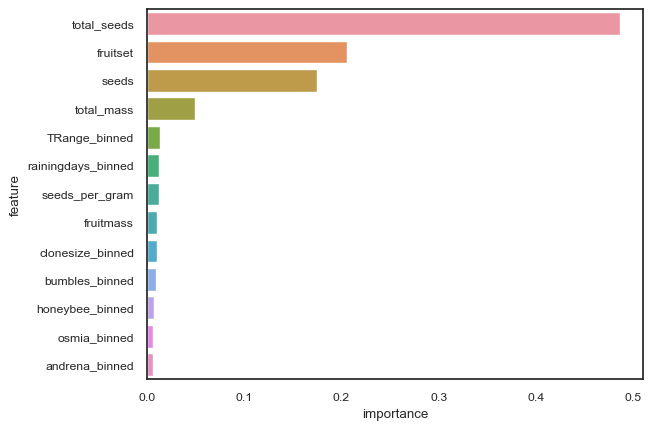

In [505]:
# Get feature importances based on gain
importances = xg.feature_importances_

feature_names = X_train.columns

# Create a dataframe of feature importances
df_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})

# Sort the dataframe by importance in descending order
df_importances = df_importances.sort_values('importance', ascending=False)

# Create a barplot of feature importances
sns.barplot(x='importance', y='feature', data=df_importances);

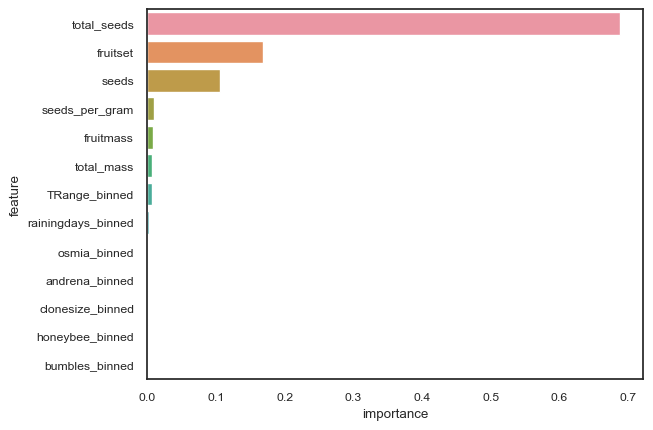

In [506]:
# Get feature importances based on gain
importances = rf.feature_importances_

feature_names = X_train.columns

# Create a dataframe of feature importances
df_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})

# Sort the dataframe by importance in descending order
df_importances = df_importances.sort_values('importance', ascending=False)

# Create a barplot of feature importances
sns.barplot(x='importance', y='feature', data=df_importances);

The bee features had little importance so we can drop most of these. We will opt to keep bumble however as this had the second-highest correlation with yield out of the bee features and didn't have a high colinearity with clonesize unlike honeybee. 

In [641]:
X_train

,fruitset,fruitmass,seeds,clonesize_binned,honeybee_binned,bumbles_binned,andrena_binned,osmia_binned,TRange_binned,rainingdays_binned,seeds_per_gram,total_mass,total_seeds
0,0.425011,0.417545,32.460887,2,2,1,5,4,1,2,77.742172,0.177461,13.796231
1,0.444908,0.422051,33.858317,2,2,1,3,4,1,2,80.223209,0.187774,15.063846
2,0.552927,0.470853,38.341781,1,1,1,4,5,3,2,81.430491,0.260347,21.200199
3,0.565976,0.478137,39.467561,1,1,1,4,4,2,2,82.544539,0.270614,22.337712
4,0.579677,0.494165,40.484512,2,2,1,4,5,2,2,81.925130,0.286456,23.467926
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15284,0.556302,0.476308,40.546480,1,1,1,2,4,2,1,85.126522,0.264971,22.556079
15285,0.354413,0.388145,29.467434,1,1,1,1,4,3,3,75.918566,0.137564,10.443643
15286,0.422548,0.416786,32.299059,2,2,1,2,6,2,3,77.495627,0.176112,13.647893
15287,0.542170,0.434133,36.674243,2,2,1,4,5,1,2,84.477072,0.235374,19.883683


In [642]:
# Drop features
X_train = X_train.drop(['osmia_binned', 'andrena_binned', 'honeybee_binned'], axis=1)
df_test = df_test.drop(['osmia_binned', 'andrena_binned', 'honeybee_binned'], axis=1)

# Also drop from validtion sets:
X_train2 = X_train2.drop(['osmia_binned', 'andrena_binned', 'honeybee_binned'], axis=1)
X_val = X_val.drop(['osmia_binned', 'andrena_binned', 'honeybee_binned'], axis=1)

We can also drop fruitmass as this has a fairly low importance value on both models compared to other numerical values and was also highly correlated with other continuous variables. 

In [649]:
# Drop features
X_train = X_train.drop('fruitmass', axis=1)
df_test = df_test.drop('fruitmass', axis=1)

# Also drop from validtion sets:
X_train2 = X_train2.drop('fruitmass', axis=1)
X_val = X_val.drop('fruitmass', axis=1)

We can re-run our models to see whether the performance has improved:

We cun use Optuna to build an Elastic Net model

In [601]:
def objective(trial):
    # Define hyperparameter ranges for the Elastic Net model
    params = {
        'alpha': trial.suggest_loguniform('alpha', 1e-6, 10),
        'l1_ratio': trial.suggest_uniform('l1_ratio', 0, 1),
        'max_iter': trial.suggest_int('max_iter', 100, 1000, step=100),
        'tol': trial.suggest_loguniform('tol', 1e-6, 1e-2)
    }

    # Train the Elastic Net model using cross-validation and return the average R2 score
    en = ElasticNet(**params)
    scores = cross_val_score(en, X_train2_ss, y_train2, cv=5, scoring='neg_mean_absolute_error')
    mae_mean = scores.mean()
    return mae_mean

study1 = optuna.create_study(direction='maximize')
study1.optimize(objective, n_trials=200)

[I 2023-05-11 11:48:13,851] A new study created in memory with name: no-name-4dc611f5-42c5-4f3e-89f3-d52cebb6d6b2
[I 2023-05-11 11:48:14,106] Trial 0 finished with value: -362.81001440314037 and parameters: {'alpha': 5.760986551249287e-05, 'l1_ratio': 0.9371982544710475, 'max_iter': 400, 'tol': 2.016133562169496e-05}. Best is trial 0 with value: -362.81001440314037.
[I 2023-05-11 11:48:14,330] Trial 1 finished with value: -362.88276644482175 and parameters: {'alpha': 0.00018386967029026958, 'l1_ratio': 0.37866668975289863, 'max_iter': 400, 'tol': 3.7650720757461956e-06}. Best is trial 0 with value: -362.81001440314037.
[I 2023-05-11 11:48:14,365] Trial 2 finished with value: -504.75690544265933 and parameters: {'alpha': 2.3722045045323643, 'l1_ratio': 0.012435292611943427, 'max_iter': 600, 'tol': 0.00033275383964197626}. Best is trial 0 with value: -362.81001440314037.
[I 2023-05-11 11:48:14,449] Trial 3 finished with value: -363.49375361608486 and parameters: {'alpha': 3.7545309437654

Now we can fit the model with the optimised parameters:

In [602]:
# Define random Elastic Net with optimised hyperparameters
en = ElasticNet(alpha=study1.best_params['alpha'],
                            l1_ratio=study1.best_params['l1_ratio'],
                            max_iter=study1.best_params['max_iter'],
                            tol=study1.best_params['tol'],
                            random_state=42)

# Fit the regressor with the training data
en.fit(X_train2_ss, y_train2)

# Make predictions on the test data
y_pred_en = en.predict(X_val_ss)

# Evaluate the performance of the model using mean absolute error
mae_en = mean_absolute_error(y_val, y_pred_en)

We can use Optuna to tune our hyperparameters for a Random Forest model:

In [524]:
# Define objective function for hyperparameter optimisation
def objective(trial):
    # Define hyperparameters to be optimized
    param = {
        'n_estimators' : trial.suggest_int('n_estimators', 50, 100),
        'max_depth' : trial.suggest_int('max_depth', 2, 10),
        'min_samples_split' : trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 1, 5)
    }
    
    # Create an XGBoost regressor model with the given hyperparameters
    rf = RandomForestRegressor(**param)

    # Compute cross-validation scores
    scores = cross_val_score(rf, X_train2, y_train2, cv=5, scoring='neg_mean_absolute_error')

    # Calculate the mean R2 score across cross-validation folds
    return scores.mean()

# Create an Optuna study and run the trials
study2 = optuna.create_study(direction='maximize') 
study2.optimize(objective, n_trials=200)

[I 2023-05-11 10:53:50,079] A new study created in memory with name: no-name-33027b39-8fbc-4842-a416-951ed70a24f7
[I 2023-05-11 10:53:53,615] Trial 0 finished with value: -440.2905719803297 and parameters: {'n_estimators': 89, 'max_depth': 2, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 0 with value: -440.2905719803297.
[I 2023-05-11 10:53:55,818] Trial 1 finished with value: -440.4295949730041 and parameters: {'n_estimators': 55, 'max_depth': 2, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 0 with value: -440.2905719803297.
[I 2023-05-11 10:53:59,372] Trial 2 finished with value: -380.32382797033995 and parameters: {'n_estimators': 68, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 2 with value: -380.32382797033995.
[I 2023-05-11 10:54:12,292] Trial 3 finished with value: -350.68848511595905 and parameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 3 with value: 

Now we can fit the model with the optimised parameters:

In [525]:
# Define random forest regressor with optimised hyperparameters
rf = RandomForestRegressor(n_estimators=study2.best_params['n_estimators'],
                            max_depth=study2.best_params['max_depth'],
                            min_samples_split=study2.best_params['min_samples_split'],
                            min_samples_leaf=study2.best_params['min_samples_leaf'],
                            random_state=42)

# Fit the regressor with the training data
rf.fit(X_train2, y_train2)

# Make predictions on the test data
y_pred_rf = rf.predict(X_val)

# Evaluate the performance of the model using mean absolute error
mae_rf = mean_absolute_error(y_val, y_pred_rf)

In [526]:
# Define objective function for hyperparameter optimisation
def objective(trial):

    # Define hyperparameters to be optimised
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 100),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'objective': 'reg:squarederror',
        'random_state': 42
    }


    # Create an XGBoost regressor model with the given hyperparameters
    xg = XGBRegressor(**param)

    # Compute cross-validation scores
    scores = cross_val_score(xg, X_train2, y_train2, cv=5, scoring='neg_mean_absolute_error')

    # Calculate the mean R2 score across cross-validation folds
    return scores.mean()

# Create an Optuna study and run the trials
study3 = optuna.create_study(direction='maximize') 
study3.optimize(objective, n_trials=200)

[I 2023-05-11 11:26:23,496] A new study created in memory with name: no-name-243bdb76-b0b5-49fa-8e9d-26d4b7834a16
[I 2023-05-11 11:26:24,044] Trial 0 finished with value: -367.9024078537959 and parameters: {'n_estimators': 85, 'max_depth': 2, 'learning_rate': 0.046185387104391434, 'subsample': 0.5668129996444121, 'colsample_bytree': 0.91199663562881, 'min_child_weight': 10}. Best is trial 0 with value: -367.9024078537959.
[I 2023-05-11 11:26:24,993] Trial 1 finished with value: -352.01808397117145 and parameters: {'n_estimators': 77, 'max_depth': 6, 'learning_rate': 0.09717387954429227, 'subsample': 0.5791363282960702, 'colsample_bytree': 0.7962329320757059, 'min_child_weight': 1}. Best is trial 1 with value: -352.01808397117145.
[I 2023-05-11 11:26:25,708] Trial 2 finished with value: -349.4653376448441 and parameters: {'n_estimators': 72, 'max_depth': 4, 'learning_rate': 0.07599372809047777, 'subsample': 0.8241738454753302, 'colsample_bytree': 0.9441492828917437, 'min_child_weight': 

In [527]:
# Define random forest regressor with optimized hyperparameters
xg = XGBRegressor(
                            n_estimators = study3.best_params['n_estimators'],
                            max_depth = study3.best_params['max_depth'],
                            learning_rate = study3.best_params['learning_rate'],
                            subsample = study3.best_params['subsample'],
                            colsample_bytree = study3.best_params['colsample_bytree'],
                            min_child_weight = study3.best_params['min_child_weight'],
                            random_state=42
)

# Fit the regressor with the training data
xg.fit(X_train2, y_train2)

# Make predictions on the test data
y_pred_xg = xg.predict(X_val)

# Evaluate the performance of the model using mean absolute error
mae_xg = mean_absolute_error(y_val, y_pred_xg)


In [528]:
# Show results
print('Elastic Net Mean Absolute Error:', mae_en.round(2))
print('Random Forest Mean Absolute Error:', mae_rf.round(2))
print('XGBoost Mean Absolute Error:', mae_xg.round(2))

Linear Regression Mean Absolute Error: 359.18
Random Forest Mean Absolute Error: 341.92
XGBoost Mean Absolute Error: 344.31


This model performs very slightly better than before but with fewer features we have reducded the time it takes to train and increased the interprability. 

Since our boosted and ensemble models have been performing best, we can try out some other types of these models to see if we can increase our performance metric further:

Catboost:

In [604]:
# Define objective function for hyperparameter optimisation
def objective(trial):

    # Define hyperparameters to be optimised
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 100),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'random_state': 42,
        'verbose': False
    }

    # Create a CatBoost regressor model with the given hyperparameters
    cb = CatBoostRegressor(**param)

    # Compute cross-validation scores
    scores = cross_val_score(cb, X_train2, y_train2, cv=5, scoring='neg_mean_absolute_error')

    # Calculate the mean R2 score across cross-validation folds
    return scores.mean()

# Create an Optuna study and run the trials
study4 = optuna.create_study(direction='maximize') 
study4.optimize(objective, n_trials=200)

[I 2023-05-11 11:51:14,456] A new study created in memory with name: no-name-7b29bd65-a6b3-445a-b9ee-274d8cee469d
[I 2023-05-11 11:51:19,101] Trial 0 finished with value: -354.7148489969817 and parameters: {'n_estimators': 86, 'max_depth': 8, 'learning_rate': 0.04594567522382148, 'subsample': 0.7335424154049194, 'colsample_bylevel': 0.9047428249099216, 'l2_leaf_reg': 1.2429652217610094}. Best is trial 0 with value: -354.7148489969817.
[I 2023-05-11 11:51:28,076] Trial 1 finished with value: -351.78355378345407 and parameters: {'n_estimators': 98, 'max_depth': 10, 'learning_rate': 0.06142407221123941, 'subsample': 0.8280281142448334, 'colsample_bylevel': 0.6595755088617343, 'l2_leaf_reg': 4.834266717852871}. Best is trial 1 with value: -351.78355378345407.
[I 2023-05-11 11:51:29,084] Trial 2 finished with value: -379.1633399726985 and parameters: {'n_estimators': 76, 'max_depth': 2, 'learning_rate': 0.04745052150440935, 'subsample': 0.6053372760634288, 'colsample_bylevel': 0.63589707409

In [605]:
# Define the CatBoost regressor with optimized hyperparameters
cb = CatBoostRegressor(
        n_estimators=study4.best_params['n_estimators'],
        max_depth=study4.best_params['max_depth'],
        learning_rate=study4.best_params['learning_rate'],
        subsample=study4.best_params['subsample'],
        colsample_bylevel=study4.best_params['colsample_bylevel'],
        l2_leaf_reg=study4.best_params['l2_leaf_reg'],
        random_state=42
)

# Fit the regressor with the training data
cb.fit(X_train2, y_train2, verbose=False)

# Make predictions on the test data
y_pred_cb = cb.predict(X_val)

# Evaluate the performance of the model using mean absolute error
mae_cb = mean_absolute_error(y_val, y_pred_cb)

LightGBM:

In [621]:
# Define objective function for hyperparameter optimisation
def objective(trial):

    # Define hyperparameters to be optimised
    param = {
        'objective': 'regression',
        'metric': 'mae',
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 50, 100),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 10),
        'random_state': 42,
        'verbosity': -1
    }

    # Create a LightGBM regressor model with the given hyperparameters
    lgbm = LGBMRegressor(**param)

    # Compute cross-validation scores
    scores = cross_val_score(lgbm, X_train2, y_train2, cv=5, scoring='neg_mean_absolute_error')

    # Calculate the mean R2 score across cross-validation folds
    return scores.mean()

# Create an Optuna study and run the trials
study5 = optuna.create_study(direction='maximize') 
study5.optimize(objective, n_trials=200)

[I 2023-05-11 12:39:08,499] A new study created in memory with name: no-name-cbdde0c8-b100-4308-9410-953cbd2dae52
[I 2023-05-11 12:39:08,820] Trial 0 finished with value: -368.7933828296907 and parameters: {'n_estimators': 68, 'max_depth': 4, 'learning_rate': 0.03804912426196965, 'subsample': 0.6907084139054233, 'colsample_bytree': 0.92008098084923, 'min_child_samples': 3}. Best is trial 0 with value: -368.7933828296907.
[I 2023-05-11 12:39:09,146] Trial 1 finished with value: -351.1408958661422 and parameters: {'n_estimators': 92, 'max_depth': 3, 'learning_rate': 0.055153698820373354, 'subsample': 0.9280964512978036, 'colsample_bytree': 0.9293334032722445, 'min_child_samples': 2}. Best is trial 1 with value: -351.1408958661422.
[I 2023-05-11 12:39:09,472] Trial 2 finished with value: -544.4537891981515 and parameters: {'n_estimators': 56, 'max_depth': 9, 'learning_rate': 0.016968596694358365, 'subsample': 0.8223581342146409, 'colsample_bytree': 0.6570862914655131, 'min_child_samples':

In [622]:
# Define the LGBMRegressor with optimized hyperparameters
lgbm = LGBMRegressor(
        n_estimators=study5.best_params['n_estimators'],
        max_depth=study5.best_params['max_depth'],
        learning_rate=study5.best_params['learning_rate'],
        subsample=study5.best_params['subsample'],
        colsample_bytree=study5.best_params['colsample_bytree'],
        min_child_samples=study5.best_params['min_child_samples'],
        random_state=42,
        verbosity=-1
)

# Fit the regressor with the training data
lgbm.fit(X_train2, y_train2)

# Make predictions on the validation data
y_pred_lgbm = lgbm.predict(X_val)

# Evaluate the performance of the model using mean absolute error
mae_lgbm = mean_absolute_error(y_val, y_pred_lgbm)

ExtraTree:

In [610]:
# Define objective function for hyperparameter optimisation
def objective(trial):

    # Define hyperparameters to be optimised
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 100),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_float('max_features', 0.5, 1),
        'random_state': 42
    }

    # Create an ExtraTrees regressor model with the given hyperparameters
    et = ExtraTreesRegressor(**param)

    # Compute cross-validation scores
    scores = cross_val_score(et, X_train2, y_train2, cv=5, scoring='neg_mean_absolute_error')

    # Calculate the mean R2 score across cross-validation folds
    return scores.mean()

# Create an Optuna study and run the trials
study6 = optuna.create_study(direction='maximize') 
study6.optimize(objective, n_trials=200)

[I 2023-05-11 12:06:32,335] A new study created in memory with name: no-name-46939ed3-af3e-46e0-8db1-c7e84c1c157e
[I 2023-05-11 12:06:32,814] Trial 0 finished with value: -470.3651316291818 and parameters: {'n_estimators': 55, 'max_depth': 2, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 0.6819057250969052}. Best is trial 0 with value: -470.3651316291818.
[I 2023-05-11 12:06:34,766] Trial 1 finished with value: -347.32714321163127 and parameters: {'n_estimators': 94, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 0.9109101466131673}. Best is trial 1 with value: -347.32714321163127.
[I 2023-05-11 12:06:35,442] Trial 2 finished with value: -436.2012058684404 and parameters: {'n_estimators': 69, 'max_depth': 2, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 0.9557290765445154}. Best is trial 1 with value: -347.32714321163127.
[I 2023-05-11 12:06:37,283] Trial 3 finished with value: -349.9696404203094 and parameters: {'n_esti

In [611]:
# Define ExtraTreesRegressor with optimized hyperparameters
et = ExtraTreesRegressor(
        n_estimators=study6.best_params['n_estimators'],
        max_depth=study6.best_params['max_depth'],
        min_samples_split=study6.best_params['min_samples_split'],
        min_samples_leaf=study6.best_params['min_samples_leaf'],
        max_features=study6.best_params['max_features'],
        random_state=42
)

# Fit the regressor with the training data
et.fit(X_train2, y_train2)

# Make predictions on the test data
y_pred_et = et.predict(X_val)

# Evaluate the performance of the model using mean absolute error
mae_et = mean_absolute_error(y_val, y_pred_et)

GradientBoosting:

In [613]:
# Define objective function for hyperparameter optimization
def objective(trial):

    # Define hyperparameters to be optimized
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 100),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'random_state': 42
    }

    # Create a Gradient Boosting Regressor model with the given hyperparameters
    gb = GradientBoostingRegressor(**param)

    # Compute cross-validation scores
    scores = cross_val_score(gb, X_train2, y_train2, cv=5, scoring='neg_mean_absolute_error')

    # Calculate the mean R2 score across cross-validation folds
    return scores.mean()

# Create an Optuna study and run the trials
study7 = optuna.create_study(direction='maximize') 
study7.optimize(objective, n_trials=200)

[I 2023-05-11 12:13:55,164] A new study created in memory with name: no-name-ef254db9-3f10-457a-9674-bdcb0f41de7f
[I 2023-05-11 12:13:57,954] Trial 0 finished with value: -377.8199039347952 and parameters: {'n_estimators': 58, 'max_depth': 3, 'learning_rate': 0.04150470318585045, 'subsample': 0.5919590670245165, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 0 with value: -377.8199039347952.
[I 2023-05-11 12:14:12,436] Trial 1 finished with value: -363.3053778610433 and parameters: {'n_estimators': 94, 'max_depth': 10, 'learning_rate': 0.07242425711948045, 'subsample': 0.7347288946868662, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 1 with value: -363.3053778610433.
[I 2023-05-11 12:14:16,148] Trial 2 finished with value: -350.3174692200798 and parameters: {'n_estimators': 95, 'max_depth': 2, 'learning_rate': 0.08572440639524438, 'subsample': 0.6520052981212905, 'min_samples_split': 4, 'min_samples_leaf': 6}. Best is trial 2 with value: -350.3174692200

In [614]:
gb = GradientBoostingRegressor(
        n_estimators=study7.best_params['n_estimators'],
        max_depth=study7.best_params['max_depth'],
        learning_rate=study7.best_params['learning_rate'],
        subsample=study7.best_params['subsample'],
        min_samples_split=study7.best_params['min_samples_split'],
        min_samples_leaf=study7.best_params['min_samples_leaf'],
        random_state=42
)

# Fit the regressor with the training data
gb.fit(X_train2, y_train2)

# Make predictions on the test data
y_pred_gb = gb.predict(X_val)

# Evaluate the performance of the model using mean absolute error
mae_gb = mean_absolute_error(y_val, y_pred_gb)

We can compare the mean absolute error scores for all our models:

In [623]:
# Show results
print('Elastic Net Mean Absolute Error:', mae_en.round(2))
print('Random Forest Mean Absolute Error:', mae_rf.round(2))
print('XGBoost Mean Absolute Error:', mae_xg.round(2))
print('Catboost Mean Absolute Error:', mae_cb.round(2))
print('LightGBM Mean Absolute Error:', mae_lgbm.round(2))
print('ExtraTree Mean Absolute Error:', mae_et.round(2))
print('GradientBoost Mean Absolute Error:', mae_gb.round(2))

Elastic Net Mean Absolute Error: 359.18
Random Forest Mean Absolute Error: 341.92
XGBoost Mean Absolute Error: 344.31
Catboost Mean Absolute Error: 347.09
LightGBM Mean Absolute Error: 345.11
ExtraTree Mean Absolute Error: 342.93
GradientBoost Mean Absolute Error: 343.02


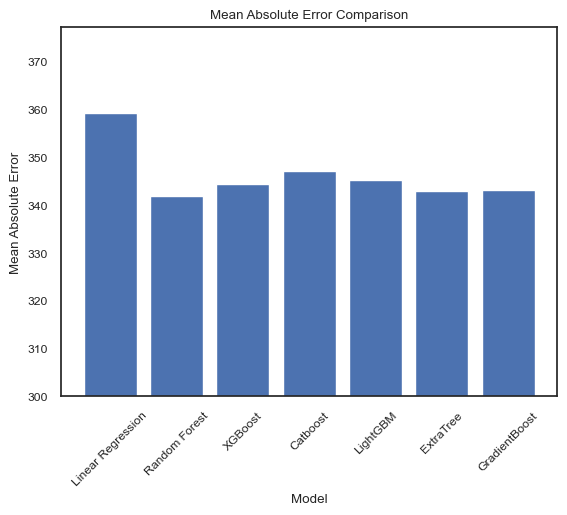

In [628]:
# Define MAE scores for each model
mae_scores = [mae_en.round(2), mae_rf.round(2), mae_xg.round(2), mae_cb.round(2), mae_lgbm.round(2), mae_et.round(2), mae_gb.round(2)]

# Define model names for each bar
model_names = ['Linear Regression', 'Random Forest', 'XGBoost', 'Catboost', 'LightGBM', 'ExtraTree', 'GradientBoost']

# Create bar chart
fig, ax = plt.subplots()
ax.bar(model_names, mae_scores)

ax.set_title('Mean Absolute Error Comparison')
ax.set_xlabel('Model')
ax.set_ylabel('Mean Absolute Error')

plt.xticks(rotation=45)

ax.set_ylim(bottom=300);

Now we can look into improving our score slightly by matching each result to the closest value in our target variable training set:

In [630]:
# First we get all the unique target variable values:
unique_targets = np.unique(df_train["yield"])

In [632]:
# Return the closest value in unique_targets for each model prediction
y_pred_rf_rounded = [min(unique_targets, key = lambda x: abs(x - pred)) for pred in y_pred_rf]

# Evaluate
mae_rf_rounded = mean_absolute_error(y_val, y_pred_rf_rounded)

# Compare
print('Random Forest Mean Absolute Error:', mae_rf.round(2))
print('Random Forest Rounded Mean Absolute Error:', mae_rf_rounded.round(2))

Random Forest Mean Absolute Error: 341.92
Random Forest Rounded Mean Absolute Error: 341.84


It is very marginal but applying this extra step increases the mean absolute error slightly.

## Building the Final Model

Since our Random Forest model worked the best on our training and validation set, we can train it on the whole training dataset before making our predictions on the test dataset. 

In [652]:
def objective(trial):
    # Define hyperparameters to be optimized
    param = {
        'n_estimators' : trial.suggest_int('n_estimators', 50, 200),
        'max_depth' : trial.suggest_int('max_depth', 2, 15),
        'min_samples_split' : trial.suggest_int('min_samples_split', 2, 15),
        'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 1, 15),
        'max_features' : trial.suggest_float('max_features', 0.1, 1.0),
        'bootstrap' : trial.suggest_categorical('bootstrap', [True, False]),
        'random_state' : 42
    }
    
    # Create a Random Forest regressor model with the given hyperparameters
    rf = RandomForestRegressor(**param)

    # Compute cross-validation scores
    scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')

    # Calculate the mean R2 score across cross-validation folds
    return scores.mean()

study_final = optuna.create_study(direction='maximize') 
study_final.optimize(objective, n_trials=300)

[I 2023-05-12 10:56:56,218] A new study created in memory with name: no-name-69d5e0eb-9804-4ace-83bf-cdb662a49ede
[I 2023-05-12 10:57:02,975] Trial 0 finished with value: -343.4904951587394 and parameters: {'n_estimators': 141, 'max_depth': 12, 'min_samples_split': 13, 'min_samples_leaf': 8, 'max_features': 0.23292916082262016, 'bootstrap': False}. Best is trial 0 with value: -343.4904951587394.
[I 2023-05-12 10:57:33,158] Trial 1 finished with value: -366.2490037356168 and parameters: {'n_estimators': 194, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': 0.9611305543049705, 'bootstrap': False}. Best is trial 0 with value: -343.4904951587394.
[I 2023-05-12 10:57:42,312] Trial 2 finished with value: -348.81845568145627 and parameters: {'n_estimators': 176, 'max_depth': 5, 'min_samples_split': 12, 'min_samples_leaf': 1, 'max_features': 0.5557669820679552, 'bootstrap': False}. Best is trial 0 with value: -343.4904951587394.
[I 2023-05-12 10:57:55,887] Trial

In [684]:
# Define random forest regressor with optimised hyperparameters
rf = RandomForestRegressor(n_estimators=study_final.best_params['n_estimators'],
                            max_depth=study_final.best_params['max_depth'],
                            min_samples_split=study_final.best_params['min_samples_split'],
                            min_samples_leaf=study_final.best_params['min_samples_leaf'],
                            max_features=study_final.best_params['max_features'],
                            bootstrap=study_final.best_params['bootstrap'],
                            random_state=42)

# Fit the regressor with the training data
rf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf.predict(df_test)

# Round to nearest unique value
y_pred = [min(unique_targets, key = lambda x: abs(x - pred)) for pred in y_pred]

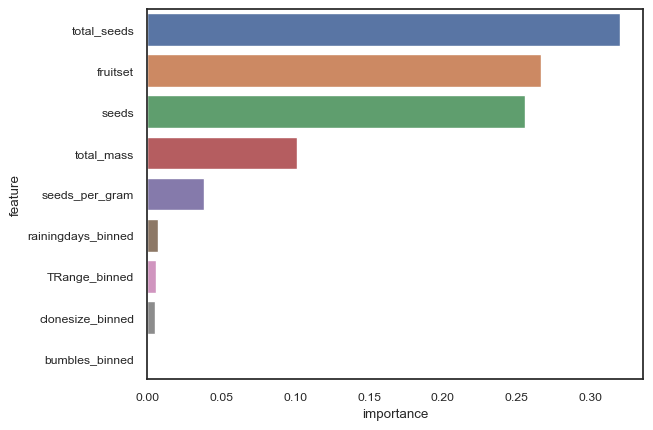

In [674]:
# Get feature importances based on gain
importances = rf.feature_importances_

feature_names = X_train.columns

# Create a dataframe of feature importances
df_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})

# Sort the dataframe by importance in descending order
df_importances = df_importances.sort_values('importance', ascending=False)

# Create a barplot of feature importances
sns.barplot(x='importance', y='feature', data=df_importances);

Finally we can convert to a dataframe to submit for the Kaggle competition:

In [685]:
# Convert to dataframe
y_pred = pd.DataFrame(y_pred, columns=['yield'])

# Load sample
sample = pd.read_csv('sample_submission.csv')

# Add sample id to predictions
y_pred['id'] = sample['id']

# Re-order columns
y_pred2 = y_pred.copy()
y_pred = y_pred.drop('yield', axis=1)
y_pred['yield'] = y_pred2['yield']


In [688]:
# Save to file
y_pred.to_csv('samk_submission.csv', index=False)